In [20]:
from scipy import *
from scipy.linalg import norm, pinv, svd
from matplotlib import pyplot as plt
from numpy.linalg import det
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error 

LAMBDA=0.0

def gendist(X,Y):
  return cdist(X,Y,metric='euclidean')

class RBF:
     
    def __init__(self, centers, outdim, R):
        indim = centers.shape[1]
        numCenters = centers.shape[0]
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = centers
        self.R = R
        self.W = np.random.random((self.numCenters, self.outdim))
        self.TRAINING_X_DATA = []
        
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return np.exp(-1/(self.R)**2 * norm(c-d)**2)
    
    def _basisfuncFast(self, c, d, dist_mat):
        print("_basisfuncFast ---> STARTED")
        ret = np.exp(-1/(self.R)**2 * dist_mat**2)
        print("_basisfuncFast ---> ENDED")
        return ret
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        
        if G.shape[0] == G.shape[1]:
           print('det(G) = ', det(G))
        
        return G
    
    def _calcActFast(self, X):
        G = np.zeros((X.shape[0], self.numCenters), float)

        self.centers = np.vstack(self.centers[:,:]).astype(np.float64)
        X = np.vstack(X[:,:]).astype(np.float64)

        dist_mat = gendist(self.centers, X)
        print("distance matrix ...  beeing calculated - STARTED")
        G = self._basisfuncFast(self.centers, X, dist_mat)
        print("distance matrix ...  beeing calculated - ENDEDED")

        print('X.shape[0]=',X.shape[0], 'self.numCenters=',self.numCenters)
       
        if G.shape[0] == G.shape[1]:
           print('det(G) = ', det(G))
        
        return G

    def wypiszZbior(self, X, tekst):
        print(tekst)
        for i in range(X.shape[0]):
            print(i,X[i,:])
        
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        self.TRAINING_X_DATA = X
        
        # self.wypiszZbior(X,'ZBIOR TRENINGOWY ----------------------->')
        G = self._calcAct(X)
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
        
    def trainRegularized(self, X, Y, _lambda=0):
        print("Regularized RBF training.")
        self.wypiszZbior(X,'ZBIOR TRENINGOWY ----------------------->')
        
        self.TRAINING_X_DATA = X
        
        G = self._calcActFast(X)
        U, S, VT = svd(G)
        self.wartosci_szczegolne = S
        
        S_inv = S*S-_lambda
        
        print('VT.shape=',VT.shape)
        print('S.shape=',S.shape)
        print('U.shape=',U.shape)
        
        N = G.shape[0]
        
        r = N
        for i in range(N):
            if S[i] < _lambda:
                r = i
                break
                
        W_final = np.zeros((G.shape[0], Y.shape[1]))
    
        for ii in range(Y.shape[1]):
            w_lambda = np.zeros(G.shape[0])
            for i in range(r):
                sigma = S[i]
                uTi = U[:,i].transpose()
                y = Y[:,ii]
                vi = VT.transpose()[:,i]
                f = sigma**2/(sigma**2+_lambda**2)
                w_lambda += 1/sigma*f*np.dot(np.dot(uTi,y),vi)
            W_final[:,ii] = w_lambda

        print('r=',r)
        
        self.W = W_final
        
    def test(self, X, treningowy = False):
        """ X: matrix of dimensions n x indim """
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y


In [21]:

def standardize(X):
    sum = 0
    for each in X:
        sum += each
    avg = sum / len(X)

    X_std = []
    for i in range(len(X)):
        normal = (avg - X[i])
        X_std.append(normal / np.linalg.norm(X[i])) 
    return np.array(X_std)

def prepare_data(data, index, limit):
    X, Y = [], []
    for i in range(len(data) - limit-1):
        x = np.array(data[i:(i+limit)]) 
        xa = x.reshape(x.shape[0] * x.shape[1])
        ya= np.array(data[(i + limit):(i + limit + 1)][index])
        X.append(xa)
        Y.append(ya)
    return np.array(X), np.array(Y)

def radius(std_data):
    max = 0
    for i in range(len(std_data)):
        for j in range(len(std_data)): 
            msr = np.linalg.norm(std_data[i] - std_data[j])
            if (max < msr): 
                max = msr
    msr = max
    radius = msr
    return radius

def Kohonen(X, T, alfa, p, learning_rate, measure, C1, C2, std):
    #if std True standaryzacja danych (punkt 2.1) srednia 0, odchylenie std 1
    if std:
        X_std = []
        sum_x = 0

        for i in range(len(X)):
            sum_x = sum_x + X[i]
        
        sr = sum_x/len(X)

        for i in range(len(X)):
            X_std.append((sr - X[i])/np.linalg.norm(sr-X[i]))
        
        X_std = np.array(X_std)
        X = X_std
    
    # inicjalizacja oraz normalizacja wektorów reprezentantów (punkt 2.2)
    vector = []
    rand_gen = np.random.RandomState(0)

    for j in range(p):
        for i in range(len(X)):
            vector_temp = rand_gen.normal(loc=0.0, scale=0.01, size=len(X[0]))
            vector.append(vector_temp/np.linalg.norm(vector_temp))
            
        representants_vector = np.array(vector)
    
    # Wybor miary (punkt 3)
    m_table = [0]*len(X)
    alfa_koh = alfa
    for i in range(T):
        if measure == 1:
            mod = measure1(X, i, p, representants_vector)
            m_table[i%len(X)] = mod

        if measure == 2:
            mod = measure2(X, i, p, representants_vector)
            m_table[i%len(X)] = mod

        if measure == 3:
            mod = measure3(X, i, p, representants_vector)
            m_table[i%len(X)] = mod

        # modyfikacja wektorów reprezentantów wg wzorów
        representants_vector[mod] = representants_vector[mod] + alfa_koh * (X[i%len(X)] - representants_vector[mod])
        representants_vector[mod] = representants_vector[mod] / np.linalg.norm(representants_vector[mod])

        # wspolczynniki uczenia
        # liniowe zmniejszanie (punkt 6)
        if learning_rate == 1:
            alfa_koh = alfa*(T-i)/T 
        
        # wykładnicze zmniejszanie (punkt 7)
        if learning_rate == 2:
            alfa_koh = alfa*math.exp(-C1*i) 
        
        # hiperboliczne zmniejszanie (punkt 8)
        if learning_rate == 3:
            alfa_koh = C1/(C2+i) 

    return representants_vector, m_table, X

def measure1(X, T_value, p, representants_vector): #miara (3)
    measurements = []
    for i in range(p):
        measurements.append(np.dot(representants_vector[i], X[T_value % len(X)]))
    
    max_index = np.where(measurements == np.amax(measurements))
    return max_index[0][0]

def measure2(X, T_value, p, representants_vector): #miara (4)
    measurements = []
    for i in range(p):
        measurements.append(np.linalg.norm(representants_vector[i] - X[T_value % len(X)]))
    
    max_index = np.where(measurements == np.amin(measurements))
    return max_index[0][0]

def measure3(X, T_value, p, representants_vector): #miara (5)
    measurements = []
    for i in range(p):
        sum_pom = 0
        for j in range(len(representants_vector[0])):
            sum_pom += abs(representants_vector[i][j] - X[T_value % len(X)][j])
        measurements.append(math.sqrt(sum_pom))
    
    max_index = np.where(measurements == np.amin(measurements))
    return max_index[0][0]


Mean Absolute Error Value for Kohonen is :  1.3314


C:\Users\aleks\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Mean Absolute Error Value for Kmeans is :  1.0379


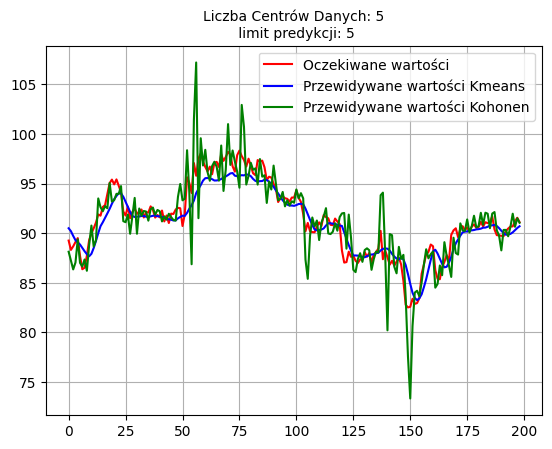

In [25]:
data = pd.read_csv('all_stocks_5yr.csv')
df = data[data['Name'] == 'DPS']
X_df = df[['open', 'high', 'low', 'close']].head(1000)

alpha = 0.1 
iter = 5000 
measure = 1 
learning_rate = 1 
C = 0.5
C2 = 0.5
std = True 
#classes = [5,10,25,50,100]
claster = 5
limit = 5
l = 1

data,expected_vals = prepare_data(X_df, 'open', limit)
std_data = standardize(data) 
X_train, X_test, y_train, y_test = train_test_split(std_data, expected_vals, test_size=0.2, shuffle=False)
centers, predicts, X = Kohonen(X_train,iter, alpha, claster, learning_rate, measure, C, C2, std)
                    # Kohonen(X, T, alfa, p, learning_rate, measure, C1, C2, std)

radius1 = radius(std_data)
rbf = RBF(centers, claster, radius1)
rbf.train(X_train, y_train)
output1 = rbf.test(X_test)

MAEValue = round(mean_absolute_error(y_test, output1),4) 
print('Mean Absolute Error Value for Kohonen is : ', MAEValue)

kmeans = KMeans(n_clusters=claster, random_state=0)
kmeans.fit(X_train)
centers = kmeans.cluster_centers_
centers = np.array(centers)

radius2 = radius(std_data)
rbf = RBF(centers, claster, radius2)
rbf.train(X_train, y_train)
output = rbf.test(X_test)

MAEValue = round(mean_absolute_error(y_test, output),4) 
print('Mean Absolute Error Value for Kmeans is : ', MAEValue)

plt.grid()
plt.plot(y_test, '-', label='Oczekiwane wartości', c='red')
plt.plot(output, '-', label='Przewidywane wartości Kmeans',c= 'blue')
plt.plot(output1, '-', label='Przewidywane wartości Kohonen',c= 'green')
plt.title("Liczba Centrów Danych: " + str(claster) + "\n limit predykcji: " + str(limit), size=10)
plt.legend()
plt.show()

In [38]:
data = pd.read_csv('all_stocks_5yr.csv')
df = data[data['Name'] == 'MSFT']
X_df = df[['open', 'high', 'low', 'close']].head(1000)

alpha = 0.1 
iter = 5000 
measure = 1 
learning_rate = 1 
C = 0.5
C2 = 0.5
std = True 
#classes = [5,10,25,50,100]
claster = 5
limit = 5
l = 1

Mean Absolute Error Value for Kohonen is :  3.6713
Mean Absolute Error Value for Kmeans is :  1.0814


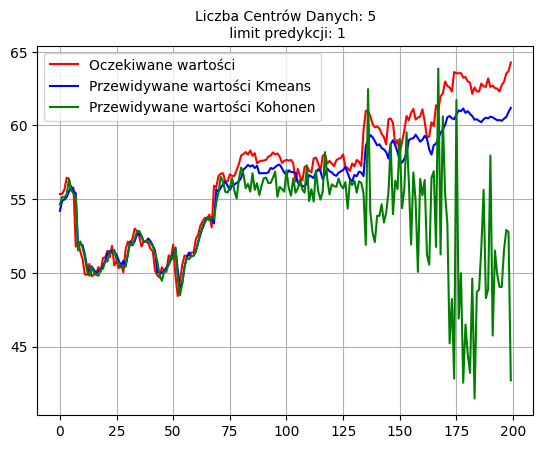

Mean Absolute Error Value for Kohonen is :  3.543
Mean Absolute Error Value for Kmeans is :  0.7265


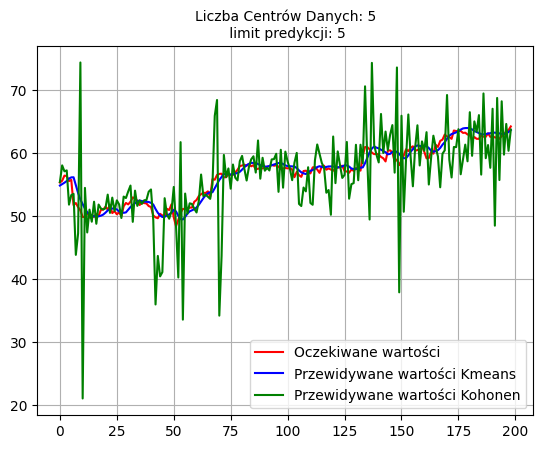

Mean Absolute Error Value for Kohonen is :  2.2378
Mean Absolute Error Value for Kmeans is :  0.8677


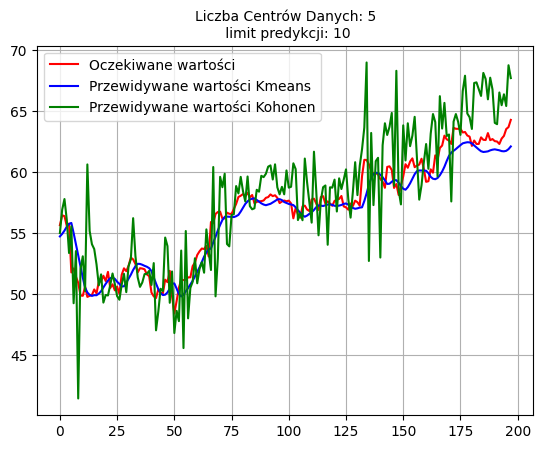

Mean Absolute Error Value for Kohonen is :  1.4716
Mean Absolute Error Value for Kmeans is :  1.2483


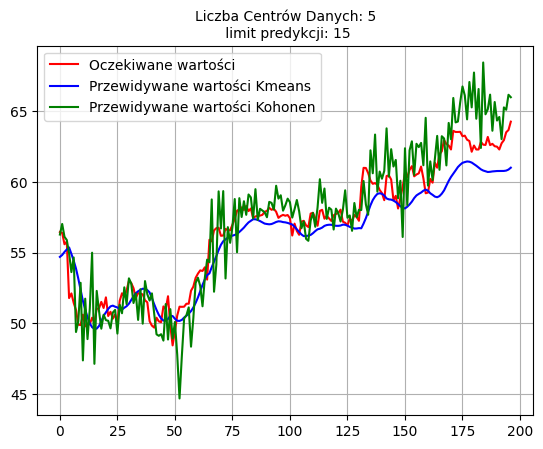

Mean Absolute Error Value for Kohonen is :  1.1281
Mean Absolute Error Value for Kmeans is :  1.5057


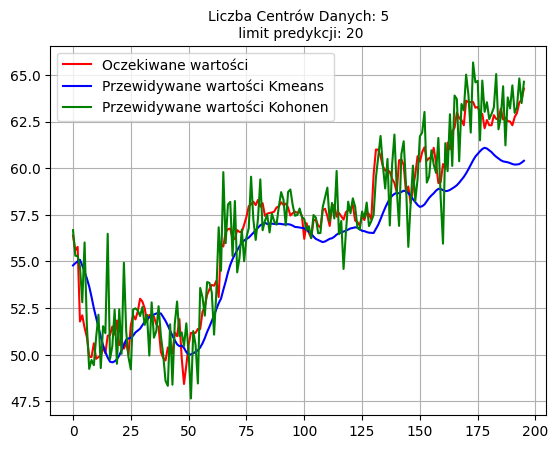

Mean Absolute Error Value for Kohonen is :  3.5615
Mean Absolute Error Value for Kmeans is :  0.6744


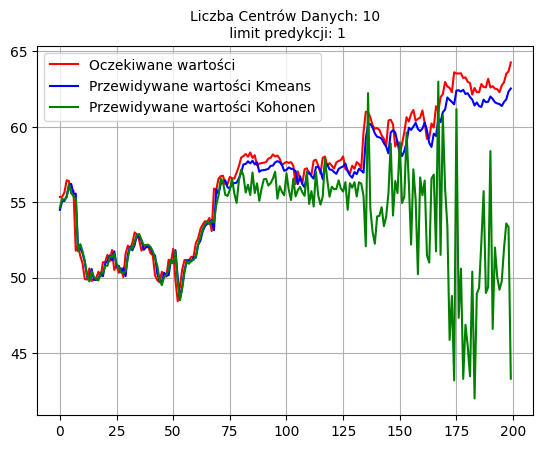

Mean Absolute Error Value for Kohonen is :  3.669
Mean Absolute Error Value for Kmeans is :  0.661


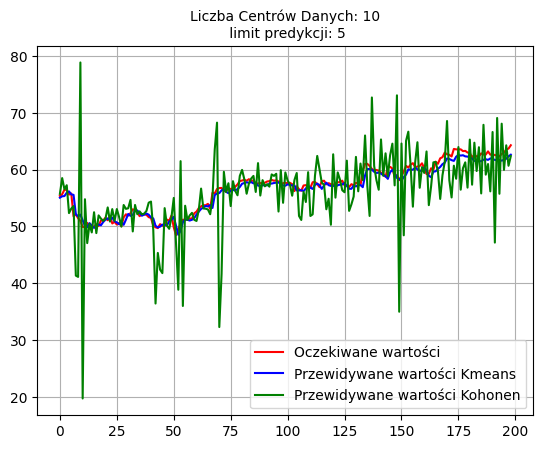

Mean Absolute Error Value for Kohonen is :  2.2528
Mean Absolute Error Value for Kmeans is :  0.8554


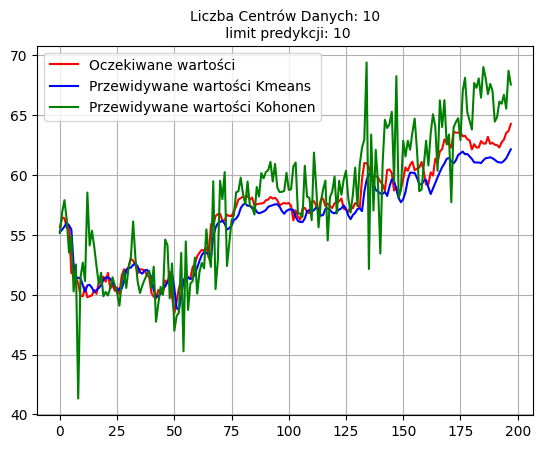

Mean Absolute Error Value for Kohonen is :  1.4608
Mean Absolute Error Value for Kmeans is :  0.5663


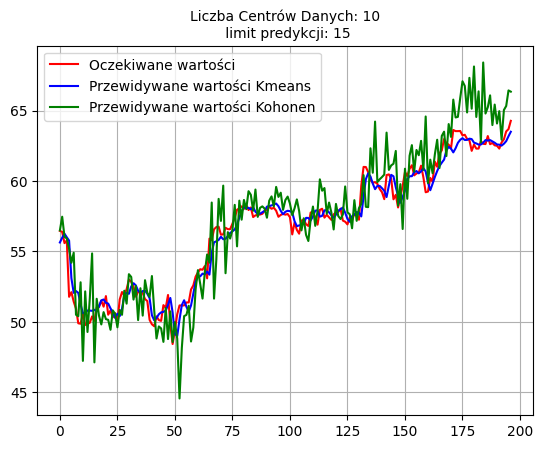

Mean Absolute Error Value for Kohonen is :  1.1598
Mean Absolute Error Value for Kmeans is :  1.2501


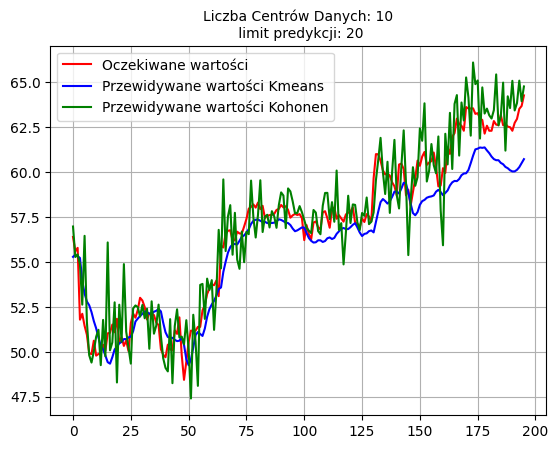

Mean Absolute Error Value for Kohonen is :  3.6379
Mean Absolute Error Value for Kmeans is :  1.1248


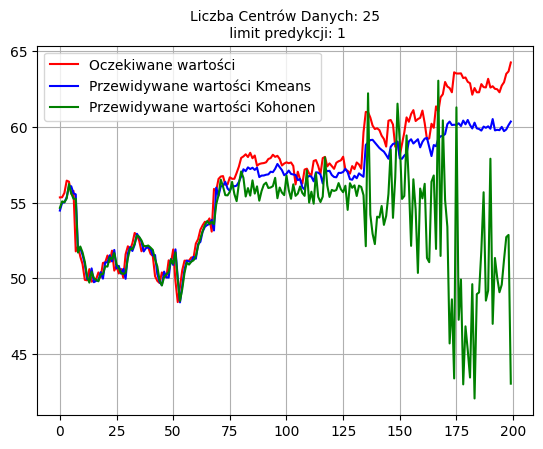

Mean Absolute Error Value for Kohonen is :  3.6369
Mean Absolute Error Value for Kmeans is :  0.6432


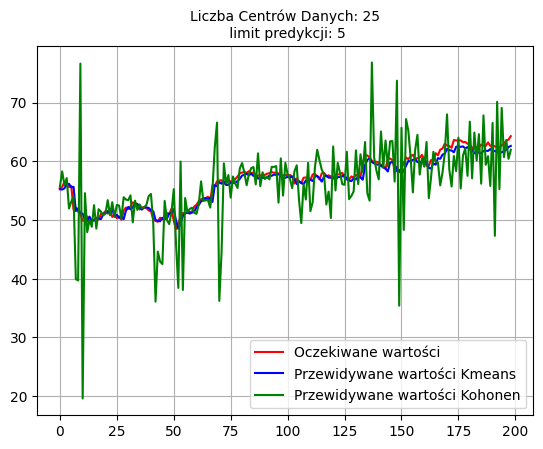

Mean Absolute Error Value for Kohonen is :  2.2009
Mean Absolute Error Value for Kmeans is :  0.6474


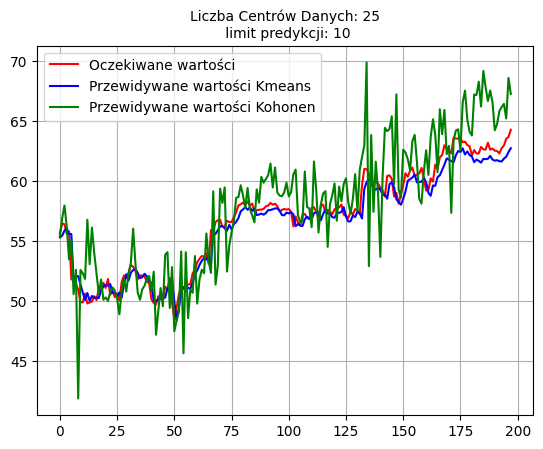

Mean Absolute Error Value for Kohonen is :  1.5236
Mean Absolute Error Value for Kmeans is :  0.6944


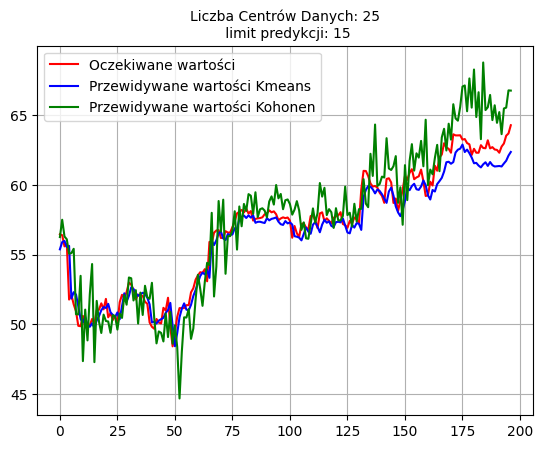

Mean Absolute Error Value for Kohonen is :  1.1609
Mean Absolute Error Value for Kmeans is :  0.664


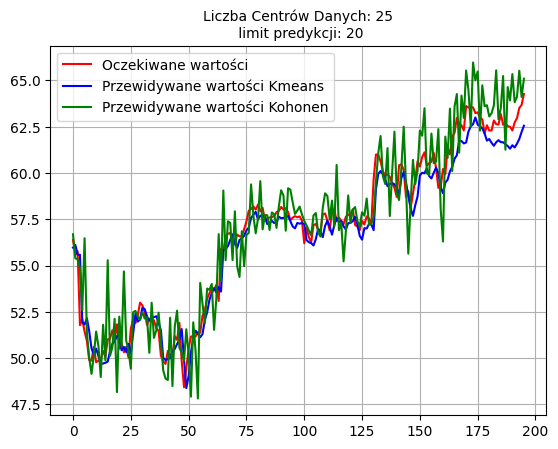

Mean Absolute Error Value for Kohonen is :  3.057
Mean Absolute Error Value for Kmeans is :  1.4627


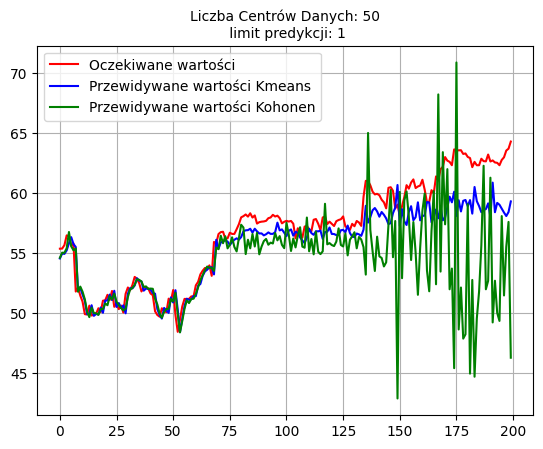

Mean Absolute Error Value for Kohonen is :  3.6071
Mean Absolute Error Value for Kmeans is :  0.4933


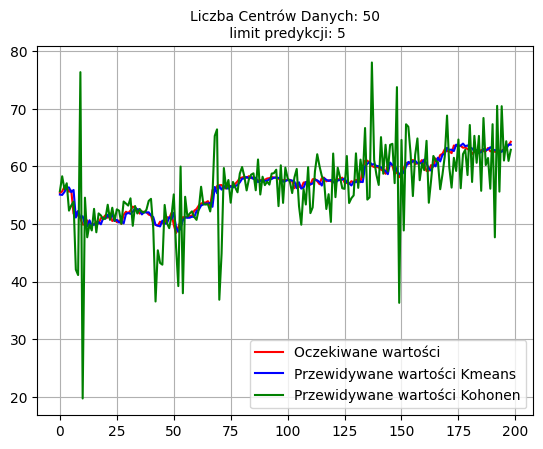

Mean Absolute Error Value for Kohonen is :  2.2201
Mean Absolute Error Value for Kmeans is :  0.6187


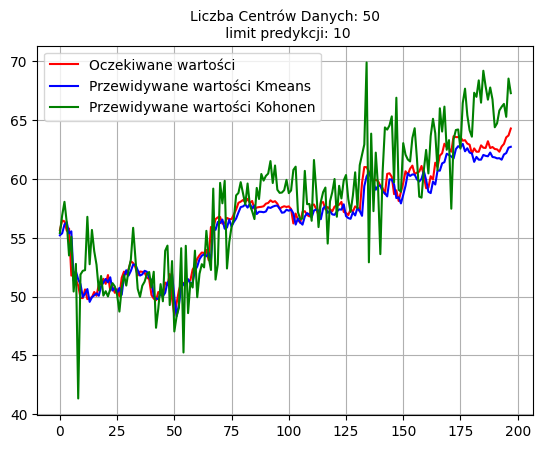

Mean Absolute Error Value for Kohonen is :  1.474
Mean Absolute Error Value for Kmeans is :  0.622


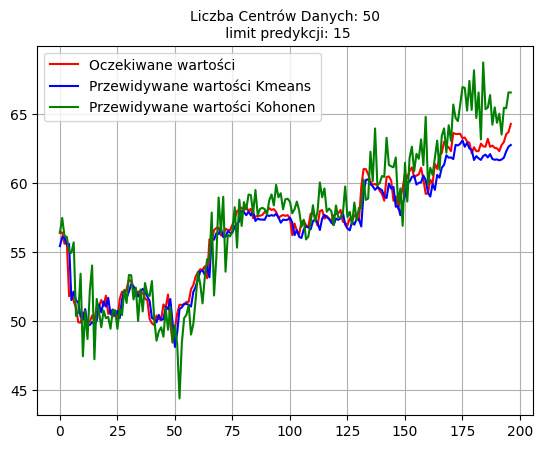

Mean Absolute Error Value for Kohonen is :  1.1592
Mean Absolute Error Value for Kmeans is :  0.5144


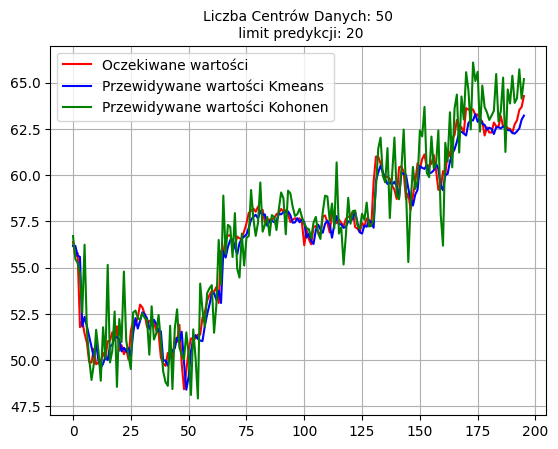

Mean Absolute Error Value for Kohonen is :  3.2638
Mean Absolute Error Value for Kmeans is :  2.0689


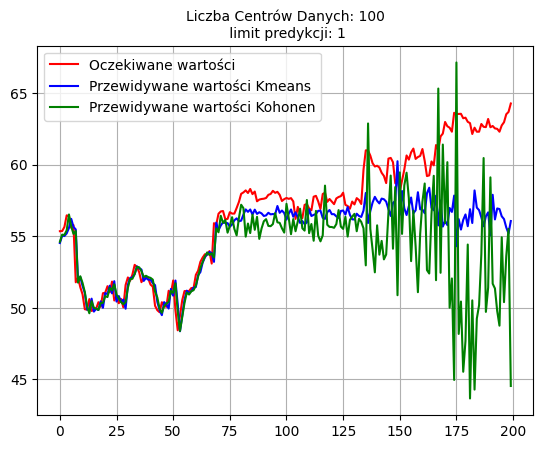

Mean Absolute Error Value for Kohonen is :  3.5959
Mean Absolute Error Value for Kmeans is :  0.5952


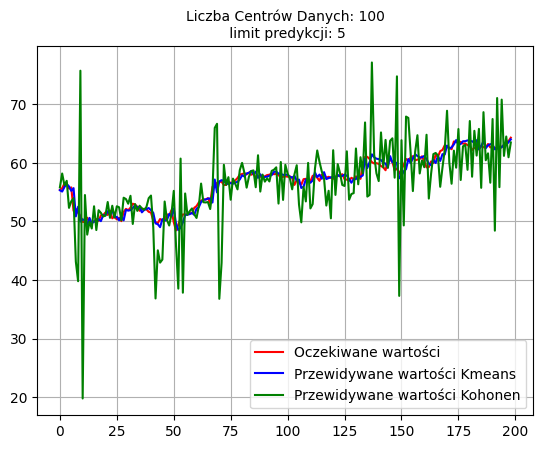

Mean Absolute Error Value for Kohonen is :  2.2629
Mean Absolute Error Value for Kmeans is :  0.5855


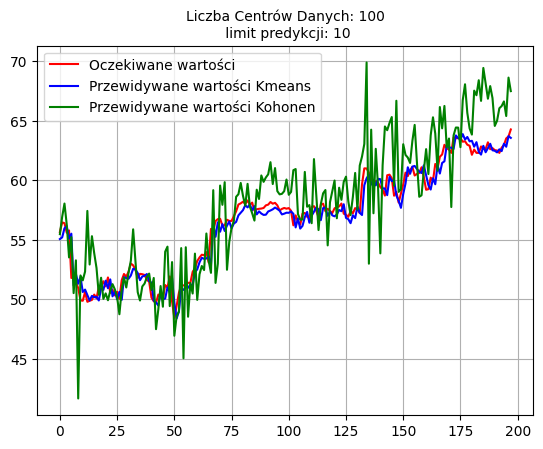

Mean Absolute Error Value for Kohonen is :  1.5156
Mean Absolute Error Value for Kmeans is :  0.5751


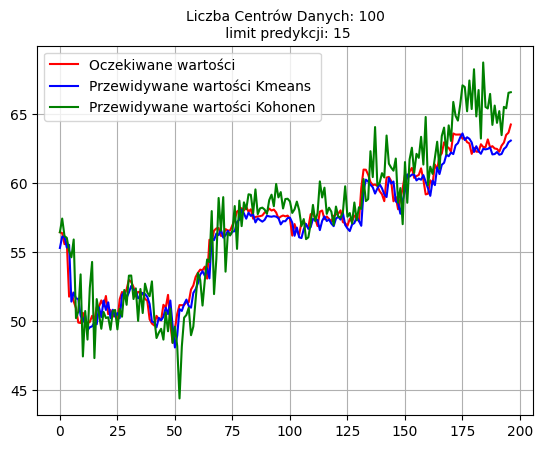

Mean Absolute Error Value for Kohonen is :  1.1618
Mean Absolute Error Value for Kmeans is :  0.5541


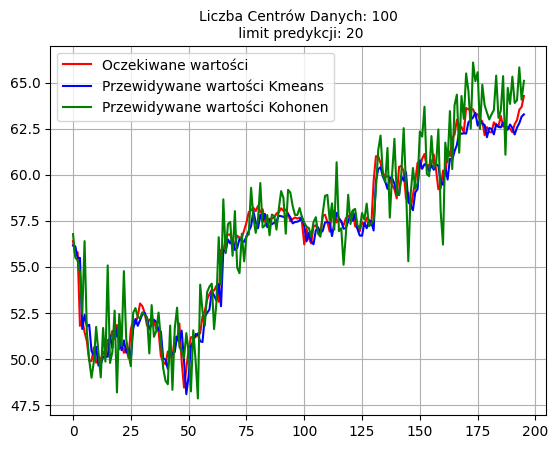

In [39]:
import warnings
warnings.filterwarnings("ignore")
cluster_values = [5,10,25,50,100]
limit_values = [1,5,10,15,20]

# Otwórz plik tekstowy do zapisu
with open("results1.txt", "w") as file:

    for claster in cluster_values:
        for limit in limit_values:
            # Preparacja danych
            data,expected_vals = prepare_data(X_df, 'close', limit)
            std_data = standardize(data) 
            X_train, X_test, y_train, y_test = train_test_split(std_data, expected_vals, test_size=0.2, shuffle=False)

            # Kohonen
            centers, predicts, X = Kohonen(X_train,iter, alpha, claster, learning_rate, measure, C, C2, std)
            radius1 = radius(std_data)
            rbf = RBF(centers, claster, radius1)
            rbf.train(X_train, y_train)
            output1 = rbf.test(X_test)
            MAEValue_kohonen = round(mean_absolute_error(y_test, output1),4) 
            print('Mean Absolute Error Value for Kohonen is : ', MAEValue_kohonen)

            # KMeans
            kmeans = KMeans(n_clusters=claster, random_state=0)
            kmeans.fit(X_train)
            centers = kmeans.cluster_centers_
            centers = np.array(centers)
            radius2 = radius(std_data)
            rbf = RBF(centers, claster, radius2)
            rbf.train(X_train, y_train)
            output = rbf.test(X_test)
            MAEValue_kmeans = round(mean_absolute_error(y_test, output),4) 
            print('Mean Absolute Error Value for Kmeans is : ', MAEValue_kmeans)

            # Rysowanie wykresu
            plt.grid()
            plt.plot(y_test, '-', label='Oczekiwane wartości', c='red')
            plt.plot(output, '-', label='Przewidywane wartości Kmeans',c= 'blue')
            plt.plot(output1, '-', label='Przewidywane wartości Kohonen',c= 'green')
            
            plt.title("Liczba Centrów Danych: " + str(claster) + "\n limit predykcji: " + str(limit), size=10)
            plt.legend()
            
            
            # Zapisanie wykresu z ustandaryzowaną nazwą
            filename = f"plot_cluster_{claster}_limit_{limit}_.png"
            plt.savefig(filename)
            plt.show()
            
            # Zapisz wyniki MAE do pliku tekstowego
            file.write(f"Cluster: {claster}, Limit: {limit}, MAE for Kohonen: {MAEValue_kohonen}, MAE for Kmeans: {MAEValue_kmeans}\n")
